<a href="https://colab.research.google.com/github/jayeshrdeotalu/Semantic-Segmentation-/blob/main/Image_Segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# THis mini-project is to do image semantic segmentation using Pytorch and Albumentation library

# importing libraries
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 945.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=55342c247abafabe3435a908c0d5babf6c76b532b05b2210385ecbfc2a98c7f9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9828b7503bc76588346dc815301cf462061c5f7f158640c74a5ca492e41cb46c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumen

In [6]:
# Importing dataset
# Dataset imported from https://github.com/VikramShenoy97/Human-Segmentation-Dataset
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.49 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [7]:
# Some commom Imports
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [8]:
# Setting up configurations and parameters
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = "/content/"

DIVICE = 'cuda'

lr = 0.003
image_size = 320
epochs = 25
batch_size = 16

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [12]:
# Reading csv and visualising dataset
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [10]:
row = df.iloc[2]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/ 255.0

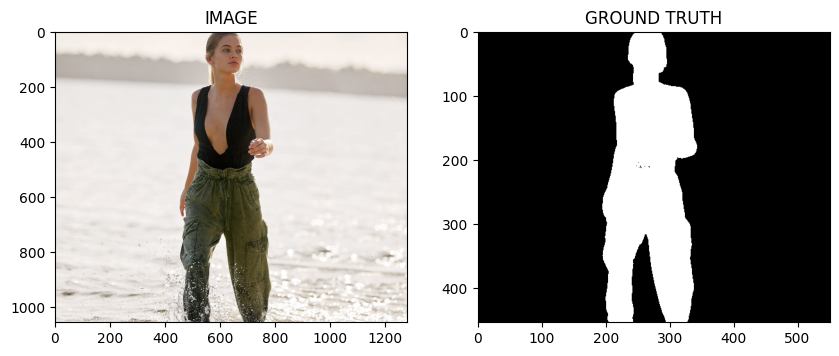

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [13]:
# spliting dataset
train, test = train_test_split(df, test_size= 0.2, random_state= 42)

In [15]:
# Data Augmentation
# Will be using albumentation

# Note -- as we only use aumentation on dataset in classification ...but in segentation we use agu on both dataset and labels also

import albumentations as A

def get_train_augs():
  return A.Compose([
      A.Resize(image_size, image_size),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
  ], is_check_shapes=False)

def get_test_augs():
  return A.Compose([
      A.Resize(image_size, image_size),       # No needd of agumentation on test dataset
      ], is_check_shapes=False)

In [16]:
# Creating Custom dataset
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # Ensure image and mask have the same dimensions
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)  # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # (h, w, c) -> (c, h, w)

        # Convert to PyTorch tensors
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask


In [17]:
train_dataset = SegmentationDataset(train, get_train_augs())
test_dataset = SegmentationDataset(test, get_test_augs())

print(f"Size of Trainset : {len(train_dataset)}")
print(f"Size of Validset : {len(test_dataset)}")

Size of Trainset : 232
Size of Validset : 58


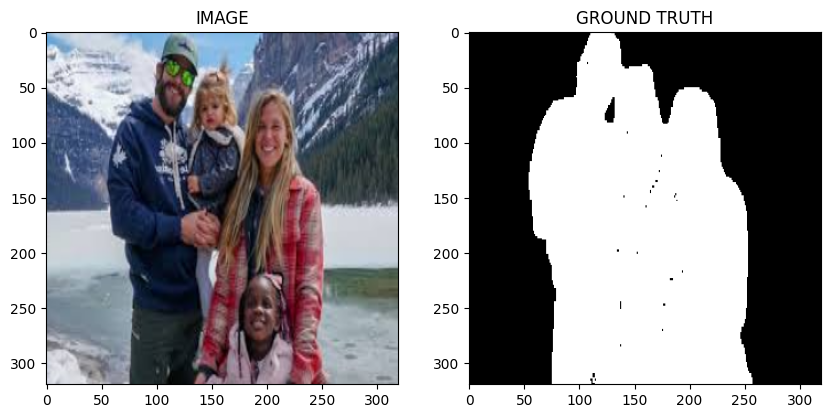

In [18]:
idx = 2

image, mask = train_dataset[idx]
helper.show_image(image, mask)

In [20]:
# Loading Data into batches
# Loding data in loader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size= batch_size)

print(f'Total batches in train loader : {len(train_loader)}')
print(f'Total batches in test loader : {len(test_loader)}')

for image, mask in train_loader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

Total batches in train loader : 15
Total batches in test loader : 4
One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


In [21]:
# Importing library for Segmentation
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DIVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 221MB/s]


In [24]:
# Creating Training and Validation Function
# ---Traning Function---
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DIVICE)
    masks = masks.to(DIVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [25]:
# ---Validation Function---
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(data_loader):

      images = images.to(DIVICE)
      masks = masks.to(DIVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)


In [26]:
# Training Function
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(test_loader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('saved-model')
    best_valid_loss = valid_loss

  print(f'Epoch : {i + 1} Train_loss : {train_loss} Valid_loss : {valid_loss}')



100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


saved-model
Epoch : 1 Train_loss : 0.7296168724695842 Valid_loss : 1.0894358903169632


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


saved-model
Epoch : 2 Train_loss : 0.3742140432198842 Valid_loss : 0.4898008704185486


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


saved-model
Epoch : 3 Train_loss : 0.3250090181827545 Valid_loss : 0.29193470627069473


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


saved-model
Epoch : 4 Train_loss : 0.2933307607968648 Valid_loss : 0.263549979776144


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


saved-model
Epoch : 5 Train_loss : 0.25065704584121706 Valid_loss : 0.22702930867671967


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Epoch : 6 Train_loss : 0.22396001716454825 Valid_loss : 0.24913713708519936


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch : 7 Train_loss : 0.19781957119703292 Valid_loss : 0.24044256284832954


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


saved-model
Epoch : 8 Train_loss : 0.17150301138559979 Valid_loss : 0.21618404611945152


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch : 9 Train_loss : 0.20033862292766572 Valid_loss : 0.22017410397529602


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 10 Train_loss : 0.1823746273914973 Valid_loss : 0.23991022258996964


100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


Epoch : 11 Train_loss : 0.21943417936563492 Valid_loss : 0.3583654686808586


100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


saved-model
Epoch : 12 Train_loss : 0.223701877395312 Valid_loss : 0.21176907792687416


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


saved-model
Epoch : 13 Train_loss : 0.15117112348477046 Valid_loss : 0.1849842555820942


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch : 14 Train_loss : 0.12738551646471025 Valid_loss : 0.18850248865783215


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch : 15 Train_loss : 0.15374414722124735 Valid_loss : 0.21165080182254314


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch : 16 Train_loss : 0.1529093489050865 Valid_loss : 0.23802783712744713


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch : 17 Train_loss : 0.14622445901234946 Valid_loss : 0.1955708358436823


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch : 18 Train_loss : 0.13601286560297013 Valid_loss : 0.19035139679908752


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


saved-model
Epoch : 19 Train_loss : 0.1070732037226359 Valid_loss : 0.163629699498415


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


saved-model
Epoch : 20 Train_loss : 0.10302786926428477 Valid_loss : 0.14872491173446178


100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


Epoch : 21 Train_loss : 0.1196642647186915 Valid_loss : 0.17168422788381577


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 22 Train_loss : 0.12943455626567205 Valid_loss : 0.17809901013970375


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch : 23 Train_loss : 0.11114870657523473 Valid_loss : 0.1679605357348919


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch : 24 Train_loss : 0.082114643851916 Valid_loss : 0.1616076808422804


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

Epoch : 25 Train_loss : 0.07972463419040045 Valid_loss : 0.1589291524142027


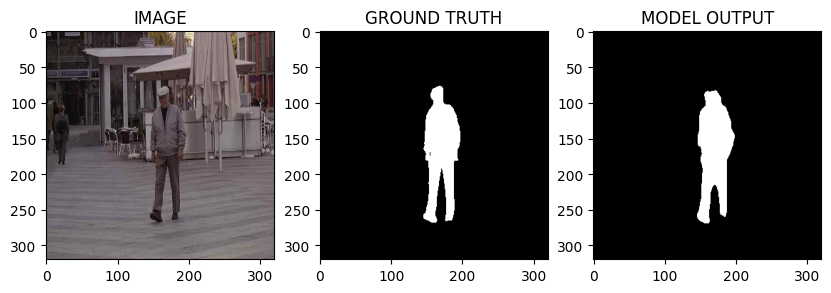

In [28]:
# Inference

idx = 28

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = test_dataset[idx]

logits_mask = model(image.to(DIVICE).unsqueeze(0)) #(c, h, w) ->> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))